## Project 2 Report - Continous Control

- Author: Thiago Akio Nakamura
- Date: May 2021
- Repo: https://github.com/akionakamura/drlnd-p2

### Introduction
This document contains the report for the Project 2 of the Deep Reinforcement Learning Nano Degree from Udacity. The goal of this project is to train an reinforcement learning agent to for a continous control problem. This report explains the algorithms used, as well as the tests parameters and the obtained results. The reader is also encouraged to read through the source code, for the detailed implementations of the neural networks and the agent itself.

### The environment
The `Reach` environment consists in a dual-jointed robotic arm that needs to follow a target location. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible. Its observation space has 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. The action space corresponds to 4 continuous variables varying between [-1, 1], where each corresponds to torque applicable to two joints.

#### The Goal
The task is episodic, and in order to solve the environment, the agent must get an average score of +30 over 100 consecutive episodes.

In [1]:
from collections import deque

from unityagents import UnityEnvironment
import numpy as np

from agents import MultiAgent

In [ ]:
# Global constants for the project.

# Number of episodes to train all agents.
NUM_EPISODES = 2000

# Consecutive runs to average the scores.
RESULT_WINDOW = 100

# Minimum average score over the window to complete the project.
MIN_AVERAGE_SCORE = 30

In [2]:
env = UnityEnvironment(file_name='./Reacher_Linux/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### Learning Algorithms

We are trying to solve the problem with Q-Learning, and besides the basic approach, we are also going to try the DoubleDQN [1] and Dueling DQN [2] approaches.

#### DDPG

In [5]:
def train(num_episodes, env, agent):
    all_scores = []
    score_window = deque(maxlen=RESULT_WINDOW)
    
    for episode_i in range(num_episodes):
    
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)

        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            agent.step(states, actions, rewards, next_states, dones)

            states = next_states                               # roll over states to next time step
            scores += env_info.rewards                         # update the score (for each agent)
            
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        agent.episode_finished()
        avg_score = np.mean(scores)
        score_window.append(avg_score)
        all_scores.append(avg_score)
        print(f"\rAvegare score on episode {episode_i}: {np.mean(score_window)}", end="")
        
    return all_scores

### Training

#### Hyper parameters

In [6]:
%%time

agent = MultiAgent(num_agents, state_size, action_size)
scores = train(NUM_EPISODES, env, agent)
scores

/home/akio/.pyenv/versions/3.6.12/envs/drlnd-p1/lib/python3.6/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/loggi/drlnd-p2/reacher/agents.py:104: UserWarning: Using a target size (torch.Size([128, 128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(Q_expected, Q_targets)


Avegare score on episode 999: 3.0151999326050283CPU times: user 3d 23h 30min 32s, sys: 9min 36s, total: 3d 23h 40min 8s
Wall time: 3d 6h 29min 35s


[0.35999999195337296,
 0.3399999924004078,
 1.289999971166253,
 0.9899999778717756,
 0.3999999910593033,
 1.6799999624490738,
 1.0699999760836363,
 1.1399999745190144,
 0.2699999939650297,
 0.7399999834597111,
 1.4299999680370092,
 0.549999987706542,
 0.7299999836832285,
 0.46999998949468136,
 0.8699999805539846,
 0.8599999807775021,
 1.0199999772012234,
 0.3499999921768904,
 1.5699999649077654,
 1.409999968484044,
 2.989999933168292,
 1.3299999702721834,
 1.2499999720603228,
 0.5599999874830246,
 0.6799999848008156,
 1.1299999747425318,
 1.5499999653548002,
 1.169999973848462,
 1.0599999763071537,
 1.699999962002039,
 2.7699999380856752,
 1.649999963119626,
 0.2899999935179949,
 1.529999965801835,
 1.7399999611079693,
 1.2799999713897705,
 1.81999995931983,
 2.419999945908785,
 1.3799999691545963,
 1.9699999559670687,
 1.409999968484044,
 2.1199999526143074,
 1.459999967366457,
 0.7699999827891588,
 0.3899999912828207,
 0.909999979659915,
 1.50999996624887,
 0.7799999825656414,
 1.099

### Results


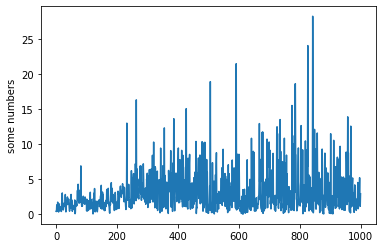

In [7]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.ylabel('some numbers')
plt.show()

When finished, you can close the environment.

In [8]:
env.close()

### Conclusion

### Future Work

### References